<a href="https://colab.research.google.com/github/gnudennis/hugggingface_demo/blob/main/02_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## bert intro

- bert: encoder of transformer
  - transformer: encoder-decoder(seq2seq)
- bert
  - embeddings
    - word(token) embedding
    - position embedding
    - token type embedding
  - encoder(12 layer)
    - mha (self attention: qkv)
    - ffn
  - pooler

transformer架构

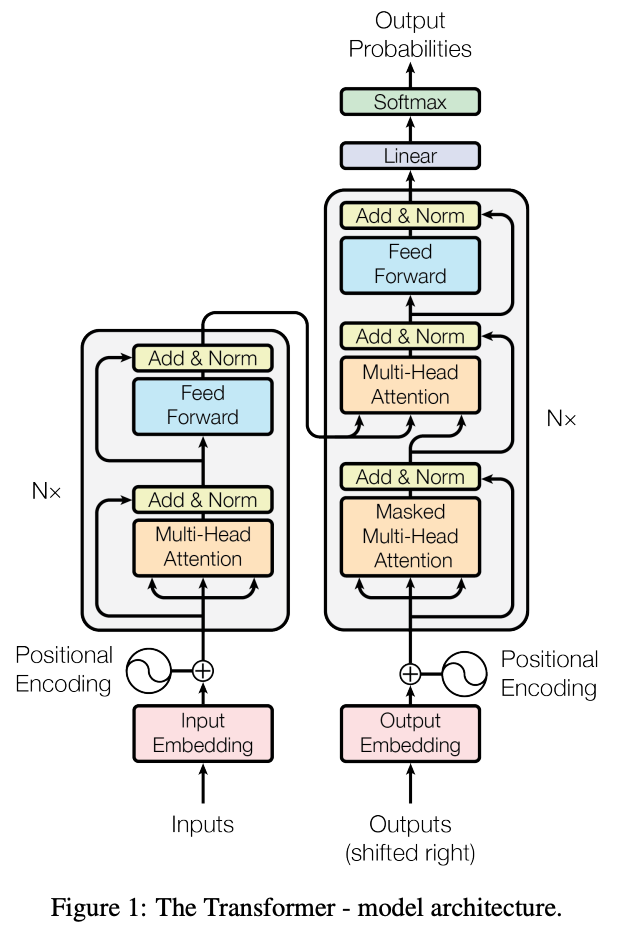

In [ ]:
!pip install datasets evaluate transformers[sentencepiece] accelerate

In [2]:
from transformers import AutoModel, AutoModelForSequenceClassification

In [3]:
model_name = 'bert-base-uncased'

In [4]:
model = AutoModel.from_pretrained(model_name)
cls_model = AutoModelForSequenceClassification.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cl

In [6]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [5]:
cls_model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [11]:
model.encoder.layer[0].attention.self.query

Linear(in_features=768, out_features=768, bias=True)

In [12]:
cls_model.classifier

Linear(in_features=768, out_features=2, bias=True)

In [22]:
# 参数量统计

total_params = 0
total_learnable_params = 0
total_embedding_params = 0
total_encoder_params = 0
total_pooler_params = 0

for name, param in model.named_parameters():
  if 'embedding' in name:
    total_embedding_params += param.numel()
  if 'encoder' in name:
    total_encoder_params += param.numel()
  if 'pooler' in name:
    total_pooler_params += param.numel()

  if param.requires_grad:
    total_learnable_params += param.numel()
  total_params += param.numel()

In [18]:
total_params, total_learnable_params

(109482240, 109482240)

In [28]:
params = (total_embedding_params, total_encoder_params, total_pooler_params)
for param in params:
  print(f'{param/sum(params)*100:.2f}%')


21.77%
77.69%
0.54%


## bert embeeding

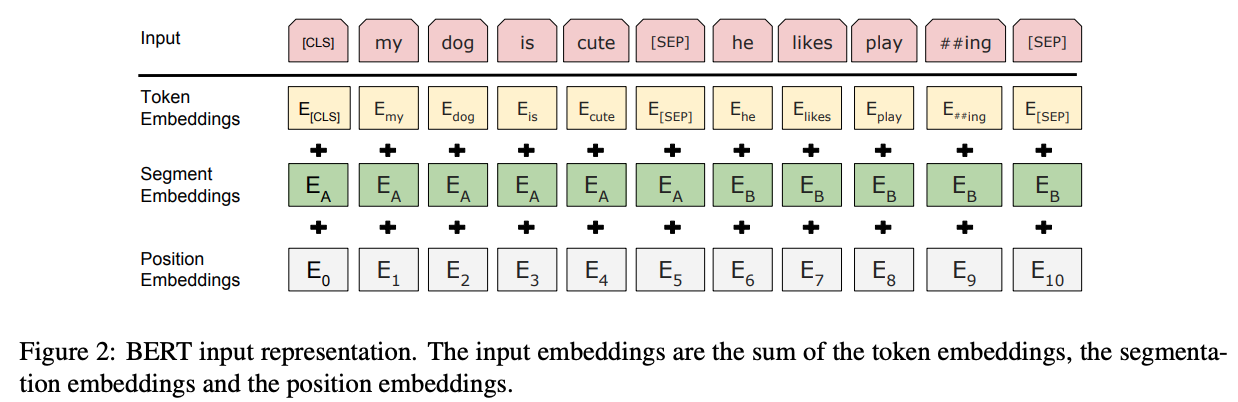

- bert input embedding: 一种查表操作（lookup table）
  - 查表
    - token embeddings: 30522*768
    - segment embeddings: 0/1 *768
    - position embeddings: 512*768
  - 后处理
    - layer norm
    - dropout

In [34]:
from transformers import AutoTokenizer, AutoModel
import torch
from torch import nn

In [35]:
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [37]:
sentence = '欢迎来到AGI时代'

In [40]:
input = tokenizer(sentence, return_tensors='pt')
input

{'input_ids': tensor([[  101,   100,   100,   100,   100, 12943,  2072,   100,  1760,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [41]:
input_ids = input['input_ids']
token_type_ids = input['token_type_ids']

In [42]:
pos_ids = torch.arange(input_ids.shape[1])
pos_ids

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [44]:
# token embedding
token_embed = model.embeddings.word_embeddings(input_ids)

In [46]:
# segment type embedding
seg_embed = model.embeddings.token_type_embeddings(token_type_ids)

In [47]:
# pos embedding
pos_embed = model.embeddings.position_embeddings(pos_ids)

In [49]:
# input embedding
input_embed = token_embed + seg_embed + pos_embed
input_embed


tensor([[[ 3.1567e-02, -4.1133e-02, -5.6440e-02,  ...,  2.1021e-03,
           4.4473e-03,  2.1946e-02],
         [-3.4291e-02, -3.5117e-02,  1.4074e-02,  ...,  2.5212e-02,
          -3.1713e-03, -5.0979e-02],
         [-5.3336e-02, -3.9342e-02,  2.1946e-02,  ...,  1.1210e-02,
          -1.4183e-02, -5.2968e-02],
         ...,
         [-4.1423e-02, -5.3467e-02,  2.5882e-02,  ...,  1.6414e-03,
          -1.7015e-02, -4.3843e-02],
         [ 1.2549e-03, -6.8392e-02, -1.4433e-02,  ..., -1.5656e-02,
          -6.8940e-02, -2.2030e-02],
         [-7.6494e-03, -2.3333e-03, -6.7711e-03,  ..., -6.5324e-03,
           7.0597e-05, -5.6649e-03]]], grad_fn=<AddBackward0>)

In [51]:
# 后处理

embed = model.embeddings.LayerNorm(input_embed)
embed = model.embeddings.dropout(embed)
embed

tensor([[[ 0.1686, -0.2858, -0.3261,  ..., -0.0276,  0.0383,  0.1640],
         [-0.3117, -0.3060,  0.5137,  ...,  0.5798,  0.2450, -0.5428],
         [-0.6267, -0.3682,  0.6441,  ...,  0.3857,  0.0773, -0.5711],
         ...,
         [-0.4240, -0.5947,  0.7099,  ...,  0.2513,  0.0351, -0.4137],
         [ 0.4410, -0.7962,  0.1899,  ...,  0.1032, -0.7518,  0.0702],
         [-0.1474, -0.0411, -0.0732,  ..., -0.1157,  0.0421, -0.0550]]],
       grad_fn=<NativeLayerNormBackward0>)

In [52]:
embed.shape

torch.Size([1, 10, 768])

## bert output